In [1]:
# Common imports
import pandas as pd
import numpy as np
import os

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import geopandas
import itertools
import seaborn as sns

#stats
import statsmodels
from statsmodels.stats.proportion import proportions_ztest
import math


In [2]:
def z_test(sample_success_a, sample_size_a, sample_success_b, sample_size_b):
    '''runs two tailed z test to compare two percentages. 
    Input = positive samples from A, sample size A, positivie samples from B, sample size B'''
    
    significance = 0.05


    successes = np.array([sample_success_a, sample_success_b])
    samples = np.array([sample_size_a, sample_size_b])

    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    # report
    print('z_stat: %0.5f, p_value: %0.5f' % (stat, p_value))
    if p_value > significance:
        print ("Fail to reject the null hypothesis - we have nothing else to say")
    else:
        print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

In [3]:
#input local file path to CRyPTIC tables
file_path='../../cryptic_data_analysis/data_tables/cryptic-analysis-group'

In [ ]:
#load files
genomes = pd.read_pickle(file_path+"/GENOMES.pkl.gz")
genomes.reset_index(level=0, inplace=True)
genomes=genomes.loc[(genomes.BELONGS_GPI==True)&(genomes.SITEID!='QC') ]
print('number of isolates =', genomes.UNIQUEID.nunique())

countries = pd.read_csv(file_path+"/COUNTRIES_LOOKUP.csv")
samples = pd.read_pickle(file_path+"/SAMPLES.pkl.gz")
samples.reset_index(level=2, inplace=True)
samples.reset_index(level=1, inplace=True)
samples.reset_index(level=0, inplace=True)
print(samples.COUNTRY_WHERE_SAMPLE_TAKEN.nunique(),'countries in total')
country_list=[]
for i in samples.COUNTRY_WHERE_SAMPLE_TAKEN.unique():
    country_list.append(i)
print(country_list)

phenotypes = pd.read_pickle(file_path+"/UKMYC_PHENOTYPES.pkl.gz")
phenotypes.reset_index(level=1, inplace=True)
phenotypes.reset_index(level=0, inplace=True)
phenotypes=phenotypes.loc[(phenotypes.BELONGS_GPI == True)
                          &(phenotypes.PHENOTYPE_QUALITY.isin(['HIGH','MEDIUM','LOW']))
                          &(phenotypes.DILUTION >=0)
                          &(phenotypes.DRUG!='PAS')
                          &(phenotypes.BINARY_PHENOTYPE.notna())]
phenotypes.loc[((phenotypes['DRUG'] =='INH')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'R'
phenotypes.loc[((phenotypes['DRUG'] =='ETH')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'S'
phenotypes.loc[((phenotypes['DRUG'] =='EMB')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'S'
print('number of isolates with phenotypes to 1+ drugs =',phenotypes.UNIQUEID.nunique())
print('number of MIC readings =',len(phenotypes))

In [328]:
#merge lineage, country and phenotype information
gs = pd.merge(genomes, samples, how='left', on=['SITEID','SUBJID','LABID'])
gs.UNIQUEID.nunique()
gps = pd.merge(gs,phenotypes, how='left', on=['UNIQUEID'])

In [12]:
#phenotype quality analysis
drug_names_list=['INH','RIF','EMB','LEV','MXF','AMI','KAN',
                 'BDQ','CFZ','DLM','LZD','ETH','RFB']
n_list=[]
hq_list=[]
mq_list=[]
lq_list=[]
fail_list=[]
for i in drug_names_list:
    n=len(phenotypes[(phenotypes.DRUG==i)])-len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE.isna())])
    n_list.append(n)
    hq=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.PHENOTYPE_QUALITY=='HIGH')])-len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE.isna())])
    hq_list.append(hq)
    mq=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.PHENOTYPE_QUALITY=='MEDIUM')])-len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE.isna())])
    mq_list.append(mq)
    lq=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.PHENOTYPE_QUALITY=='LOW')])-len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE.isna())])
    lq_list.append(lq)

quality_df=pd.DataFrame(list(zip(drug_names_list,n_list,hq_list,mq_list,lq_list)), 
                 columns=['DRUG','PHENOTYPES','HIGH_QUALITY','MEDIUM_QUALITY','LOW_QUALITY'])
quality_df.to_csv('phenotype_quality_per_drug.csv')
quality_df

,DRUG,PHENOTYPES,HIGH_QUALITY,MEDIUM_QUALITY,LOW_QUALITY
0,INH,12070,9519,1351,1200
1,RIF,12099,8955,1356,1788
2,EMB,12158,7506,1355,3297
3,LEV,12163,7774,1354,3035
4,MXF,12194,6785,1353,4056
5,AMI,12072,8973,1350,1749
6,KAN,12130,9333,1355,1442
7,BDQ,12068,8536,1355,2177
8,CFZ,12049,7763,1352,2934
9,DLM,11927,8095,1349,2483


In [11]:
#total number of phenotypes 
n_list=[]
hq_list=[]
mq_list=[]
lq_list=[]
fail_list=[]
for i in ['ALL']:
    n=len(phenotypes)-len(phenotypes[(phenotypes.BINARY_PHENOTYPE.isna())])
    n_list.append(n)
    hq=len(phenotypes[(phenotypes.PHENOTYPE_QUALITY=='HIGH')])-len(phenotypes[(phenotypes.BINARY_PHENOTYPE.isna())])
    hq_list.append(hq)
    mq=len(phenotypes[(phenotypes.PHENOTYPE_QUALITY=='MEDIUM')])-len(phenotypes[(phenotypes.BINARY_PHENOTYPE.isna())])
    mq_list.append(mq)
    lq=len(phenotypes[(phenotypes.PHENOTYPE_QUALITY=='LOW')])-len(phenotypes[(phenotypes.BINARY_PHENOTYPE.isna())])
    lq_list.append(lq)
quality_df=pd.DataFrame(list(zip(n_list,hq_list,mq_list,lq_list)), 
                 columns=['PHENOTYPES','HIGH_QUALITY','MEDIUM_QUALITY','LOW_QUALITY'])
quality_df

,PHENOTYPES,HIGH_QUALITY,MEDIUM_QUALITY,LOW_QUALITY
0,157401,109243,17592,30566


   DRUG  PHENOTYPES      S     R         %S         %R
0   INH       12070   6161  5909  51.043911  48.956089
1   RIF       12099   7414  4685  61.277792  38.722208
2   EMB       12158   9897  2261  81.403191  18.596809
3   LEV       12163  10017  2146  82.356327  17.643673
4   MXF       12194  10470  1724  85.861899  14.138101
5   AMI       12072  11189   883  92.685553   7.314447
6   KAN       12130  11009  1121  90.758450   9.241550
7   BDQ       12068  11959   109  99.096785   0.903215
8   CFZ       12049  11524   525  95.642792   4.357208
9   DLM       11927  11741   186  98.440513   1.559487
10  LZD       12189  12033   156  98.720158   1.279842
11  ETH       12132  10405  1727  85.764919  14.235081
12  RFB       12150   7685  4465  63.251029  36.748971


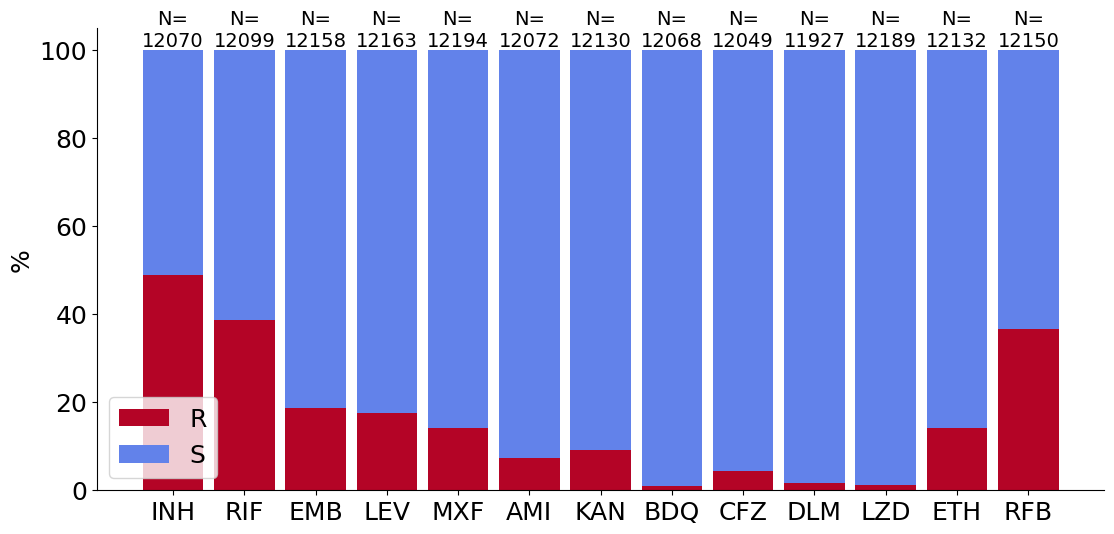

In [18]:
#proportion of isolates resistant and susceptible to each drug
drug_names_list=['INH','RIF','EMB','LEV','MXF','AMI','KAN',
                 'BDQ','CFZ','DLM','LZD','ETH','RFB']
t_list=[]
s_list=[]
r_list=[]
i_list=[]
for i in drug_names_list:
    t=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE.notna())])
    t_list.append(t)
    s=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE=='S')])
    s_list.append(s)
    r=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE=='R')])
    r_list.append(r)
sr_df=pd.DataFrame(list(zip(drug_names_list,t_list,s_list,r_list)), 
                 columns=['DRUG','PHENOTYPES','S','R'])
sr_df['%S']=sr_df['S']/sr_df['PHENOTYPES']*100
sr_df['%R']=sr_df['R']/sr_df['PHENOTYPES']*100

print(sr_df)
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.figure(figsize=(len(drug_names_list),6))

N = len(drug_names_list)
L1 = sr_df['%R']
L2 = sr_df['%S']


ind = np.arange(N)    # the x locations for the groups
width = 0.85       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, L1, width, color= '#b40426')
p2 = plt.bar(ind, L2, width, bottom=L1, color='#6282ea')



plt.ylabel('%')
plt.title('')
plt.xticks(ind, (drug_names_list))

for i in range(0,N):
    plt.text(i, 100, 'N=\n'+str(n_list[i]), ha = 'center', va='bottom')

plt.legend((p1[0], p2[0]), 
           ('R', 'S'), 
           loc='lower left')
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False) 



plt.savefig('R_S_per_drug.png', dpi=300, transparent=True, bbox_inches='tight')

In [14]:
#create dataframe and 'drugs_df.csv' containing each isolates resistance profile to the 13 drugs. 1 = resistant, 0 = susceptible, np.nan = no reading
drugs_df = pd.DataFrame(columns=['UNIQUEID','INH','RIF','EMB', 'LEV','MXF','AMI','KAN',
                 'BDQ','CFZ','DLM','LZD','ETH','RFB'])
drug_names_list=['INH','RIF','EMB','LEV','MXF','AMI','KAN',
                 'BDQ','CFZ','DLM','LZD', 'ETH','RFB']
for U in phenotypes.UNIQUEID.unique():
        u_list=[]
        rs=phenotypes[phenotypes.UNIQUEID==U]
        list1=[]
        list1.append(U)
        for drug in drug_names_list:
            if rs.loc[rs['DRUG']==drug].BINARY_PHENOTYPE.values =='R':
                list1.append(1)
            elif rs.loc[rs['DRUG']==drug].BINARY_PHENOTYPE.values =='S':
                list1.append(0)
            else:
                list1.append(np.nan)
        df_length = len(drugs_df)
        drugs_df.loc[df_length] = list1
drugs_df=drugs_df.set_index(drugs_df['UNIQUEID'], drop=True)
drugs_df=drugs_df.drop(columns=['UNIQUEID'])
print(len(drugs_df))
drugs_df.to_csv('drugs_df.csv')

<ipython-input-14-fa820aea3330>:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if rs.loc[rs['DRUG']==drug].BINARY_PHENOTYPE.values =='R':
<ipython-input-14-fa820aea3330>:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif rs.loc[rs['DRUG']==drug].BINARY_PHENOTYPE.values =='S':


12289


In [19]:
#number of isolates with phenotype for all 13 drugs
drugs_df=pd.read_csv('drugs_df.csv', index_col='UNIQUEID')
listna=drugs_df.isnull().sum(axis=1).tolist()
from collections import Counter
print(Counter(listna))
print('Number of isolates with phenotypes for all drugs =', Counter(listna)[0])

Counter({0: 10821, 1: 1030, 2: 237, 3: 91, 4: 49, 5: 25, 6: 17, 7: 10, 9: 3, 11: 3, 8: 2, 10: 1})
Number of isolates with phenotypes for all drugs = 10821


In [20]:
#isolates resistant to all 13 drugs
totr_list=drugs_df.loc[drugs_df.sum(1)==13].index.tolist()

df=gs.loc[(gs.UNIQUEID.isin(totr_list))]
u_list=df.UNIQUEID.to_list()
lin_list=df.LINEAGE_NAME.to_list()
country_list=df.COUNTRY_WHERE_SAMPLE_TAKEN.to_list()

allR_df=pd.DataFrame(list(zip(u_list,country_list,lin_list)), 
                 columns=['UNIQUEID','COUNTRY','LINEAGE'])
allR_df.to_csv('totally_resistant_isolates.csv')
allR_df

,UNIQUEID,COUNTRY,LINEAGE
0,site.11.subj.XTB-18-224.lab.XTB-18-224.iso.1,NaN,Lineage 2
1,site.10.subj.YA00026182.lab.YA00026182.iso.1,ZAF,Lineage 4


In [21]:
def R_COUNTS(subset, country):
    '''Creates row in dataframe showing numbers of MDR/XDR etc isolates in a country'''
    no_s=0
    no_mdr_rr=0
    no_pre_xdr=0
    no_xdr=0
    no_other=0
    count=0
    r_count=0
    inh_r=0
    rif_r=0
    randi_s=0

    total_list=[]
    for U in subset.UNIQUEID.unique():
        if U in drugs_df.index.tolist():
            x=drugs_df.loc[U]
            x=x.fillna(0)
            count=count+1
            if ((x.RIF)==1 and (x.LEV+x.MXF)>=1 and (x.BDQ+x.LZD)>=1):
                no_xdr=no_xdr+1
            if (x.RIF==1 and (x.LEV+x.MXF)>=1):
                no_pre_xdr=no_pre_xdr+1
            if ((x.sum()!=0)&(x['INH']+x['RIF']<=1)):
                no_other=no_other+1
            if (x.sum()==0):
                no_s=no_s+1
            if (x.sum()>=1):
                r_count=r_count+1
            if ((x.sum()!=0)&(x['INH']+x['RIF']<=1)&(x['INH']==1)):
                inh_r=inh_r+1
            if ((x.sum()!=0)&(x['INH']+x['RIF']<=1)&(x['RIF']==1)):
                rif_r=rif_r+1
            if (x['RIF']==1):
                no_mdr_rr=no_mdr_rr+1
            if ((x.sum()!=0)&(x['RIF']!=1)&(x['INH']!=1)):
                randi_s=randi_s+1   

    df = pd.DataFrame({
        "COUNTRY":[country],
        "S":[no_s],
        "MDR/RR":[no_mdr_rr],
        "XDR":[no_xdr],
        "PRE_XDR":[(no_pre_xdr-no_xdr)],
        "RIF_R":[rif_r],
        "INH_R":[inh_r],
        "RANDI_S":[randi_s],
        "TOTAL":[count],
        "NO_R":[r_count]
        })
    return df


In [22]:
#calculate number of each phenotype in total dataset
total=R_COUNTS(gps, 'TOTAL')
#calculate number of each phenotype in each country and append to dataframe
for i in gps.COUNTRY_WHERE_SAMPLE_TAKEN.unique():
    total=total.append(R_COUNTS(gps[(gps.COUNTRY_WHERE_SAMPLE_TAKEN==i)],str(i)))
nan=R_COUNTS(gps[(gps.COUNTRY_WHERE_SAMPLE_TAKEN.isnull())|(gps.COUNTRY_WHERE_SAMPLE_TAKEN=='None')],'UNKNOWN')
counts_df=total.append(nan)
counts_df.reset_index(inplace=True)
zero_index=counts_df.loc[counts_df['TOTAL']==0].index
counts_df=counts_df.drop(zero_index)
counts_df=counts_df.sort_values(by='TOTAL', ascending=False)
counts_df

,index,COUNTRY,S,TDR,MDR,MDR/RR,R,XDR,XDR_OLD,PRE_XDR,FQ_R,INJ_R,RIF_R,INH_R,RANDI_S,TOTAL,NO_R
0,0,TOTAL,5475,129,4082,4685,2461,142,539,1819,1961,995,332,1556,573,12289,6814
2,0,PER,1378,0,795,853,465,0,83,140,140,174,58,356,51,2638,1260
25,0,UNKNOWN,921,17,857,977,541,33,153,373,406,246,70,342,129,2369,1448
8,0,ZAF,653,74,416,655,449,49,108,231,280,225,116,242,91,1641,988
9,0,IND,555,21,700,770,162,30,82,508,538,119,19,78,65,1468,913
1,0,CHN,645,10,238,276,199,15,27,106,121,49,13,80,106,1107,462
4,0,VNM,497,0,106,114,332,0,1,12,12,7,8,251,73,935,438
18,0,PAK,51,2,371,387,62,3,19,186,189,28,11,42,9,489,438
12,0,DEU,321,1,72,86,43,7,7,18,25,24,6,32,5,444,123
7,0,BRA,157,0,70,83,113,2,1,14,16,8,11,66,36,342,185


<ipython-input-121-9c54244a1ee3>:12: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  mypie2, _ = ax.pie([
<ipython-input-121-9c54244a1ee3>:21: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  mypie3, _ = ax.pie([ data.PRE_XDR[0]/total,


[<matplotlib.patches.Wedge object at 0x1210afeb0>, <matplotlib.patches.Wedge object at 0x122a3f9a0>]


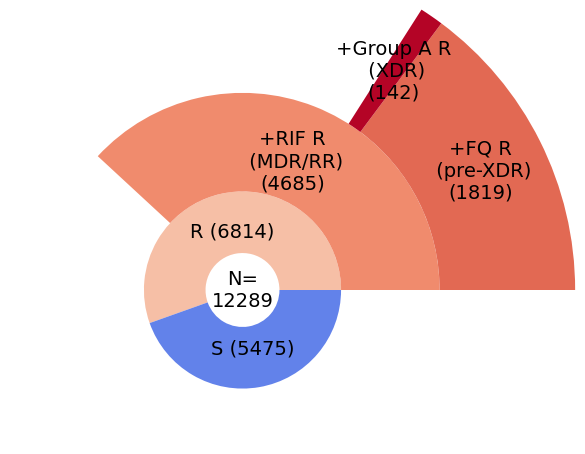

In [121]:
#pie chart of resistance phenotypes
data=counts_df.loc[counts_df.COUNTRY=='TOTAL']
total=data.TOTAL[0]
# First Ring (outside)
fig, ax = plt.subplots(figsize=(6,4))
ax.axis('equal')
mypie, _ = ax.pie([data.NO_R[0]/total,(data.TOTAL[0]-data.NO_R[0])/total], radius=0.8, labels=['R ('+str(data.NO_R[0])+')','S ('+str(data.TOTAL[0]-data.NO_R[0])+')'], 
                  labeldistance=0.6, startangle=0,
                  textprops=dict(color="k",size=14, horizontalalignment="center", verticalalignment='center'),colors=['#f6bfa6', '#6282ea'])
plt.setp( mypie, width=0.5)
 
# Second Ring 
mypie2, _ = ax.pie([
                    (data['MDR/RR'][0])/total], radius=0.8+0.8, startangle=0, 
                    labels=[
                            '+RIF R\n (MDR/RR)\n('+str(data['MDR/RR'][0])+')'], 
                    labeldistance=0.7, colors=['#f08b6d'], rotatelabels=False, 
                    textprops=dict(color="k",size=14, horizontalalignment="center", verticalalignment='center'))
plt.setp( mypie2, width=0.8)
plt.margins(0,0)

mypie3, _ = ax.pie([ data.PRE_XDR[0]/total,
                    (data.XDR[0])/total ], 
                    radius=0.8+1.9, labeldistance=0.8, colors=['#e26953','#b40426'], 
                    rotatelabels=False,  startangle=0,
                    labels=['+FQ R\n (pre-XDR)\n('+str(data.PRE_XDR[0])+')',
                            '+Group A R\n (XDR)\n('+str(data.XDR[0])+')'], 
                            textprops=dict(color="k",size=14, horizontalalignment="center", verticalalignment='center'))
print(mypie3)
plt.setp( mypie3, width=1.1)
plt.margins(0,0)



plt.text(0,0,"N=\n"+str(len(drugs_df)), horizontalalignment='center', verticalalignment='center', size=14)
plt.savefig('full_dataset_pie_mdronly.png', dpi=300, transparent=True, bbox_inches='tight')


In [24]:
#percentages
data=counts_df.loc[counts_df.COUNTRY=='TOTAL']
print("%R =",data.NO_R[0]/data.TOTAL[0]*100)
print("% of R isolates that are MDR/RR =",(data['MDR/RR'][0])/(data.NO_R[0])*100)
print('% of MDR isolates that are XDR =', (data.XDR[0])/(data['MDR/RR'][0])*100)
print('% of MDR isolates that are PRE_XDR =', (data.PRE_XDR[0])/(data['MDR/RR'][0])*100)
print('% of XDR isolates that are R to a NRD =', (data.TDR[0])/(data.TDR[0]+data.XDR[0])*100)


%R = 55.44796159166735
% of R isolates that are MDR/RR = 68.75550337540358
% of MDR isolates that are XDR = 3.030949839914621
% of MDR isolates that are PRE_XDR = 38.826040554962646
% of XDR isolates that are R to a NRD = 47.601476014760145


In [126]:
#create world df for % of isoaltes that were R to at least 1 drug
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
tb_world=pd.merge(world, counts_df, left_on='iso_a3', right_on='COUNTRY', how='left')
#tb_world = tb_world[(world.name!="Antarctica")]
tb_world['%R']=(tb_world['TOTAL']-tb_world['S'])/tb_world['TOTAL']*100
tb_world['R']=tb_world['TOTAL']-tb_world['S']
tb_world['%S']=tb_world['S']/tb_world['TOTAL']*100
tb_world_n=tb_world.loc[(tb_world['R']>0)]
tb_world_n=pd.merge(tb_world_n,countries, how='left', left_on='COUNTRY', right_on='COUNTRY_CODE_3_LETTER')
#create world df for proportions of R phenotypes seen in countries with >99 R isolates
tb_world_r=tb_world.loc[(tb_world['NO_R'])>=100]
tb_world_r=pd.merge(tb_world_r,countries, how='left', left_on='COUNTRY', right_on='COUNTRY_CODE_3_LETTER')
lat=tb_world_r.LAT
long=tb_world_r.LONG
#pick out R categories for pie charts
r1=tb_world_r.RANDI_S +tb_world_r.INH_R
r2=tb_world_r.INH_R
r4=(tb_world_r['MDR/RR'] - tb_world_r.PRE_XDR - tb_world_r.XDR)
r5=tb_world_r.PRE_XDR
r7=tb_world_r.XDR
tot=tb_world_r['MDR/RR']+tb_world_r.R
unknown_df=counts_df.loc[counts_df.COUNTRY=='UNKNOWN']
u1=unknown_df.RANDI_S.to_list()[0]+unknown_df.INH_R.to_list()[0]
u2=(unknown_df['MDR/RR'].to_list()[0] - unknown_df.PRE_XDR.to_list()[0] - unknown_df.XDR.to_list()[0])
u3=unknown_df.PRE_XDR.to_list()[0]
u4=unknown_df.XDR.to_list()[0]

In [ ]:
#adapt color map
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0.2, 0.65)

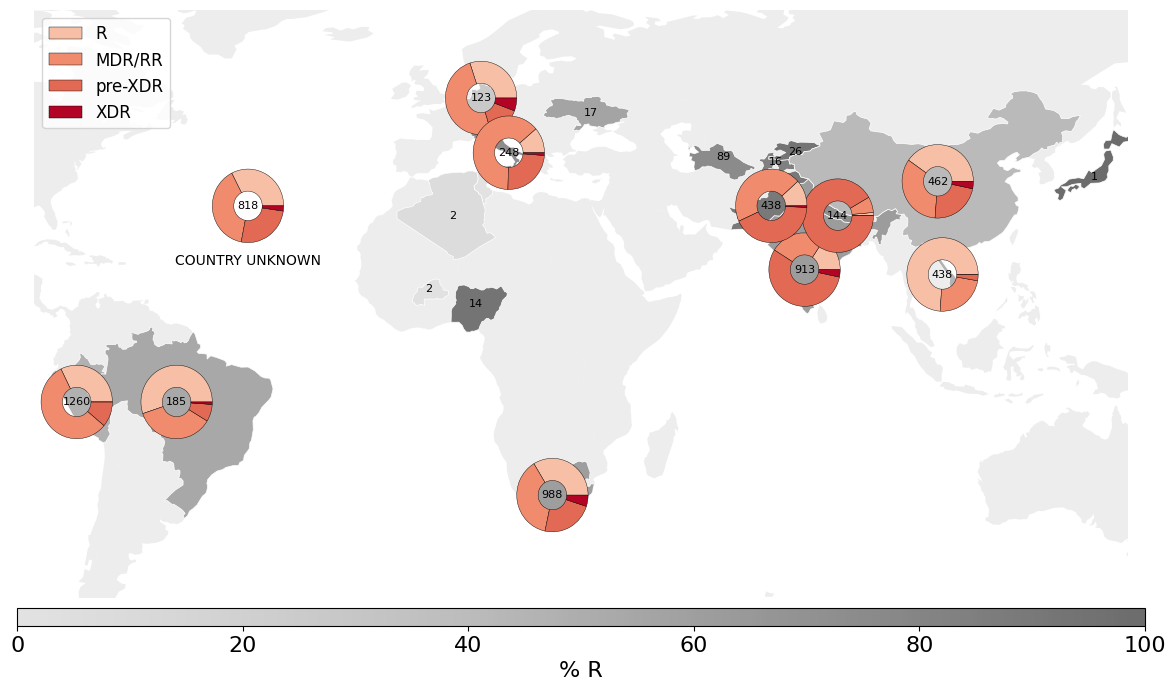

In [131]:

#make graph
fig, ax = plt.subplots(1, 1,figsize=(15,8))
for i in range(len(tb_world_r)):
    if tb_world_r.COUNTRY[i]=='DEU':
        center=(long[i],lat[i]+1)
    elif tb_world_r.COUNTRY[i]=='IND':
        center=(long[i],lat[i]-3)
    elif tb_world_r.COUNTRY[i]=='ITA':
        center=(long[i]+2,lat[i]-2)
    else:
        center=(long[i],lat[i])
    patches, texts=ax.pie([r1[i],r4[i],r5[i], r7[i]],radius=7.5,
                   colors=['#f6bfa6','#f08b6d', '#e26953','#b40426'], 
                          center=center)
    plt.setp( patches, width=4.5, edgecolor='k', linewidth=0.3)
    ax.legend(patches,['R','MDR/RR','pre-XDR','XDR'], 
              fontsize=12,loc='upper left')
    
for i in range(len(tb_world_n)):
    if tb_world_n.COUNTRY[i]=='DEU':
        plt.text(tb_world_n.LONG[i],tb_world_n.LAT[i]+1, tb_world_n.R.astype('int64').to_list()[i], ha='center', va='center', size=8)
    elif tb_world_n.COUNTRY[i]=='IND':
        plt.text(tb_world_n.LONG[i],tb_world_n.LAT[i]-3, tb_world_n.R.astype('int64').to_list()[i], ha='center', va='center', size=8)
    elif tb_world_n.COUNTRY[i]=='ITA':
        plt.text(tb_world_n.LONG[i]+2,tb_world_n.LAT[i]-2, tb_world_n.R.astype('int64').to_list()[i], ha='center', va='center', size=8)
    else:
        plt.text(tb_world_n.LONG[i],tb_world_n.LAT[i], tb_world_n.R.astype('int64').to_list()[i], ha='center', va='center', size=8)
    


center=(-40,30)
patches, texts=ax.pie([u1,u2,u3,u4],radius=7.5,
                   colors=['#f6bfa6','#f08b6d', '#e26953','#b40426'], 
                          center=center)
plt.setp( patches, width=4.5, edgecolor='k', linewidth=0.3)
plt.text(-40,18, 'COUNTRY UNKNOWN', ha='center', size=10)
plt.text(-40,30, str(int(6184-tb_world_n['R'].sum())), ha='center', va='center', size=8)

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0.1)
background=world.plot(ax=ax, alpha=0.4, color='lightgray')
wp=tb_world.plot(ax=ax,edgecolor="w", linewidth=0.5,
                 column="%R",
                 figsize=(10, 10),
                 cmap=new_cmap,
                 legend=True, cax=cax,
                 legend_kwds={'label': "% R",'orientation': "horizontal"})



ax.set_xlim(-85,145)
ax.set_ylim(-50,70)
cax.tick_params(labelsize=16)
cax.set_xlabel('% R',fontsize=16)
plt.savefig('pies_map_fig_mdronly.png', dpi=300, transparent=True, bbox_inches='tight')

In [27]:
#calculate number of each phenotype in total dataset

lin_total=R_COUNTS(gps, 'TOTAL')

#calculate number of each phenotype in each lineage and append to dataframe
for i in sorted(gps.LINEAGE_NAME.unique()):
    print(i)
    if i == '':
        lin_total=lin_total.append(R_COUNTS(gps[(gps.LINEAGE_NAME==i)],'Non-mtb'))
    else:
        lin_total=lin_total.append(R_COUNTS(gps[(gps.LINEAGE_NAME==i)],str(i)))
nan=R_COUNTS(gps[(gps.LINEAGE_NAME.isnull())],'NON MTB')
lin_counts_df=lin_total.append(nan)
lin_counts_df.reset_index(inplace=True)
zero_index=lin_counts_df.loc[lin_counts_df['TOTAL']==0].index
lin_counts_df=lin_counts_df.drop(zero_index)
lin_counts_df


Lineage 1
Lineage 2
Lineage 3
Lineage 4
Lineage 6


,index,COUNTRY,S,TDR,MDR,MDR/RR,R,XDR,XDR_OLD,PRE_XDR,FQ_R,INJ_R,RIF_R,INH_R,RANDI_S,TOTAL,NO_R
0,0,TOTAL,5475,129,4082,4685,2461,142,539,1819,1961,995,332,1556,573,12289,6814
1,0,Non-mtb,10,0,0,0,4,0,0,0,0,0,0,2,2,14,4
2,0,Lineage 1,430,3,107,128,140,6,7,38,44,13,12,78,50,686,256
3,0,Lineage 2,1444,103,1849,2143,843,91,345,1071,1162,593,100,586,157,4330,2886
4,0,Lineage 3,434,5,436,485,171,13,28,206,219,40,31,92,48,1059,625
5,0,Lineage 4,3151,18,1690,1929,1303,32,159,504,536,349,189,798,316,6194,3043
6,0,Lineage 6,6,0,0,0,0,0,0,0,0,0,0,0,0,6,0


In [28]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 1'].reset_index()
print((data['MDR/RR'][0]))
print((data['MDR/RR'][0]+data['PRE_XDR'][0]+data['XDR'][0])/data.NO_R[0]*100)


128
67.1875


In [29]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 2'].reset_index()
print((data['MDR/RR'][0]))
(data['MDR/RR'][0])/data.NO_R[0]*100

2143


74.25502425502427

In [30]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 3'].reset_index()
print((data['MDR/RR'][0]))
(data['MDR/RR'][0])/data.NO_R[0]*100

485


77.60000000000001

In [31]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 4'].reset_index()
print((data['MDR/RR'][0]))
print((data['MDR/RR'][0]+data['PRE_XDR'][0]+data['XDR'][0])/data.NO_R[0]*100)

1929
81.00558659217877


In [32]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 1'].reset_index()
print(data.PRE_XDR[0])
(data.PRE_XDR[0])/(data['MDR/RR'][0])*100

38


29.6875

In [33]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 2'].reset_index()
print(data.PRE_XDR[0])
(data.PRE_XDR[0])/(data['MDR/RR'][0])*100

1071


49.976668222118526

In [34]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 3'].reset_index()
print(data.PRE_XDR[0])
(data.PRE_XDR[0])/(data['MDR/RR'][0])*100

206


42.47422680412371

In [35]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 4'].reset_index()
print(data.PRE_XDR[0])
(data.PRE_XDR[0])/(data['MDR/RR'][0])*100

504


26.127527216174183

In [36]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 1'].reset_index()
print(data.XDR[0])
(data.XDR[0])/((data['MDR/RR'][0]))*100

6


4.6875

In [37]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 2'].reset_index()
print(data.XDR[0])
(data.XDR[0])/((data['MDR/RR'][0]))*100

91


4.246383574428371

In [38]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 3'].reset_index()
print(data.XDR[0])
(data.XDR[0])/((data['MDR/RR'][0]))*100

13


2.6804123711340204

In [39]:
data=lin_counts_df.loc[lin_counts_df.COUNTRY=='Lineage 4'].reset_index()
print(data.XDR[0])
(data.XDR[0])/((data['MDR/RR'][0]))*100

32


1.6588906168999482

In [40]:
#make resistance phenotpye by lineage graphs

#remove lineages outside of the major 4 (L1,L2,L3,L4)
lin_counts_df=lin_counts_df.loc[(lin_counts_df['COUNTRY']!='Non-mtb')&(lin_counts_df['COUNTRY']!='Lineage 6')&(lin_counts_df['COUNTRY']!='TOTAL')]

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.figure(figsize=(12, len(lin_counts_df)))

N = len(lin_counts_df)

#calculate percentages of each phenotype in each lineage
P1 = ((lin_counts_df['RANDI_S'].values+lin_counts_df['INH_R'].values)/lin_counts_df['NO_R'].values*100)
P2 = ((lin_counts_df['MDR/RR'].values-lin_counts_df['PRE_XDR'].values-lin_counts_df['XDR'].values)/lin_counts_df['NO_R'].values*100)
P3 = (lin_counts_df['PRE_XDR'].values/lin_counts_df['NO_R'].values*100)
P4 = (lin_counts_df['XDR'].values/lin_counts_df['NO_R'].values*100)




ind = np.arange(N)    # the x locations for the groups
width = 0.85       

#plot stacked bars
p1 = plt.barh(ind, P1, width, color='#f6bfa6')
p2 = plt.barh(ind, P2, width, left=P1, color='#f08b6d')
p3 = plt.barh(ind, P3, width, left=P1+P2, color='#e26953')
p4 = plt.barh(ind, P4, width, left=P1+P2+P3, color='#b40426')



plt.xlabel('%')
plt.title('')
plt.yticks(ind, (['Lineage 1','Lineage 2','Lineage 3','Lineage 4']))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

for i in range(0,N):
    plt.text(104, i, 'N=\n'+str(lin_counts_df['NO_R'].values[i]), ha = 'center', va='center')


plt.savefig('lineage_R.png', dpi=300, transparent=True, bbox_inches='tight')




,index,COUNTRY,S,TDR,MDR,MDR/RR,R,XDR,XDR_OLD,PRE_XDR,FQ_R,INJ_R,RIF_R,INH_R,RANDI_S,TOTAL,NO_R
0,0,TOTAL,5475,129,4082,4685,2461,142,539,1819,1961,995,332,1556,573,12289,6814
1,0,Non-mtb,10,0,0,0,4,0,0,0,0,0,0,2,2,14,4
2,0,Lineage 1,430,3,107,128,140,6,7,38,44,13,12,78,50,686,256
3,0,Lineage 2,1444,103,1849,2143,843,91,345,1071,1162,593,100,586,157,4330,2886
4,0,Lineage 3,434,5,436,485,171,13,28,206,219,40,31,92,48,1059,625
5,0,Lineage 4,3151,18,1690,1929,1303,32,159,504,536,349,189,798,316,6194,3043
6,0,Lineage 6,6,0,0,0,0,0,0,0,0,0,0,0,0,6,0


In [42]:

#make dataframe of percentage of a drug that is resistant to each of the others

drug_names_list=['INH','RIF', 'EMB', 'LEV','MXF','AMI', 'KAN','BDQ','CFZ','DLM','LZD', 'ETH', 'RFB']

#create copy of drug_df (resistance profile of each isolate to 13 drugs)
mdr_df=drugs_df
print(len(mdr_df))

#create dataframe of drug 1 name, drug 2 name, number os isolates resistant to both drugs and total samples with phenotpyes for both drugs
mdr_df2 = pd.DataFrame(columns=['drug1','drug2', 'instance', 'total'])
for i,j in (list(itertools.product(drug_names_list, repeat=2))):
    list2=[]
    list2.append(i)
    list2.append(j)
    list2.append(len(mdr_df[(mdr_df[i]==1)&(mdr_df[j]==1)]))
    i_mdr_df=mdr_df.loc[mdr_df[i]==1]
    list2.append(len(i_mdr_df)-len(i_mdr_df[(i_mdr_df[j].isna())]))
    df_length = len(mdr_df2)
    mdr_df2.loc[df_length] = list2

#create lists of lists for instances and totals by each drug
big_list=[]
t_list=[]
for i in drug_names_list:
    x=mdr_df2.loc[mdr_df2['drug1']==i].instance.to_list()
    big_list.append(x)
    t=mdr_df2.loc[mdr_df2['drug1']==i].total.to_list()
    t_list.append(t)
    
#create arrays and divide positive samples by totals
mdr_array=np.array(big_list)
t_array=np.array(t_list)
array_list=[]
for i in range(0,len(mdr_array)):
    array_list.append(mdr_array[i]/t_array[i])
prop_array=np.array(array_list)

#turn into percentages
percent_array=np.round(prop_array*100,1)

#turn array into dataframe indexed by drug
index = drug_names_list
columns = drug_names_list
df = pd.DataFrame(percent_array, index=index, columns=columns).astype('float')
print(df)

12289
[5909, 4353, 2220, 1993, 1632, 815, 991, 85, 320, 100, 118, 1645, 4133]
[5909, 5823, 5849, 5867, 5873, 5808, 5838, 5810, 5811, 5731, 5863, 5843, 5867]
[4353, 4685, 2157, 1925, 1585, 790, 962, 84, 275, 79, 107, 1359, 4267]
[4655, 4685, 4656, 4650, 4653, 4599, 4624, 4603, 4603, 4541, 4643, 4630, 4674]
[2220, 2157, 2261, 1213, 1061, 518, 590, 53, 182, 51, 83, 804, 1971]
[2253, 2249, 2261, 2249, 2251, 2220, 2236, 2212, 2227, 2185, 2244, 2243, 2258]
[1993, 1925, 1213, 2146, 1679, 575, 663, 65, 200, 61, 101, 835, 1863]
[2137, 2134, 2132, 2146, 2140, 2108, 2119, 2104, 2117, 2073, 2127, 2132, 2139]
[1632, 1585, 1061, 1679, 1724, 507, 589, 54, 168, 44, 91, 719, 1527]
[1717, 1717, 1715, 1721, 1724, 1694, 1703, 1690, 1698, 1657, 1707, 1714, 1719]
[815, 790, 518, 575, 507, 883, 794, 21, 113, 44, 71, 357, 728]
[876, 874, 879, 880, 877, 883, 878, 869, 866, 850, 877, 877, 879]
[991, 962, 590, 663, 589, 794, 1121, 20, 117, 35, 63, 448, 894]
[1108, 1109, 1113, 1114, 1108, 1103, 1121, 1104, 1100, 

<Figure size 1200x1000 with 0 Axes>

In [43]:
#difference between RIF+FRB resistance and RFB+RIF resistance
z_test(mdr_array[1,12],t_array[1,12],mdr_array[12,1],t_array[12,1])
#difference between LEV+MXF resistance and MXF+LEV resistance
z_test(mdr_array[3,4],t_array[3,4],mdr_array[4,3],t_array[4,3])
#difference between AMI+KAN resistance and KAN+AMI resistance
z_test(mdr_array[5,6],t_array[5,6],mdr_array[6,5],t_array[6,5])

z_stat: -11.07171, p_value: 0.00000
Reject the null hypothesis - suggest the alternative hypothesis is true
z_stat: -17.52641, p_value: 0.00000
Reject the null hypothesis - suggest the alternative hypothesis is true
z_stat: 10.22795, p_value: 0.00000
Reject the null hypothesis - suggest the alternative hypothesis is true


<ipython-input-49-2ea869a5b6c7>:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('heatmap_fig_numbers.png', dpi=300, tightlayout=True, transparent=True)


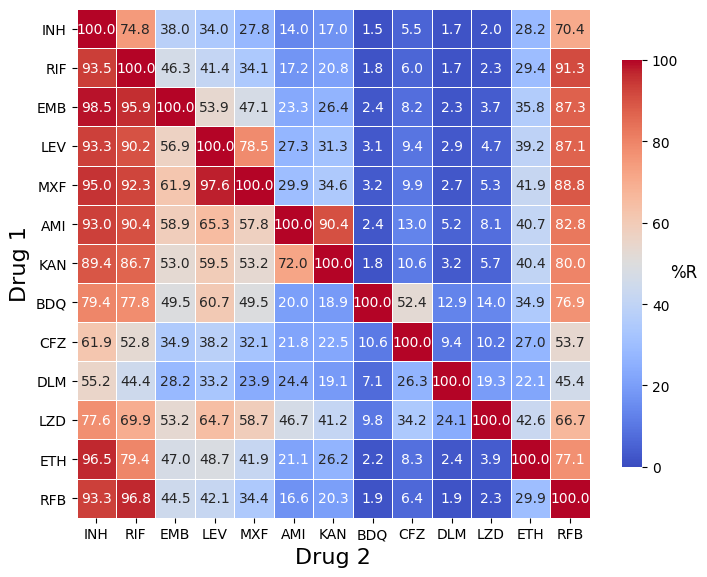

In [49]:
#make heatmap figure
plt.figure(figsize=(7.5, 6))
ax=sns.heatmap(df, cmap='coolwarm', linewidths=0.5, annot=True, fmt='.1f', annot_kws={"size":10},
               vmax=100,vmin=0,cbar=True, cbar_kws={'shrink':0.8}) #mask=mask,
ax.set_yticklabels(drug_names_list,rotation=0, size=10)
ax.set_xticklabels(drug_names_list,rotation=0, size=10)
cbar = ax.collections[0].colorbar
cbar.set_label('%R', rotation=0, size=12)
cbar.set_ticks([0, 20, 40, 60,80,100])
cbar.ax.tick_params(labelsize=10)
cbar.set_ticklabels(['0', '20', '40', '60','80','100'])
#for t in ax.texts: t.set_text(t.get_text() + "%")
ax.set_ylabel('Drug 1', size=16)
ax.set_xlabel('Drug 2', size=16)
plt.tight_layout()
plt.savefig('heatmap_fig_numbers.png', dpi=300, tightlayout=True, transparent=True)

In [273]:
def make_other_drugs_graphs(fls_df, drugs_list, color, file_name):
    '''takes dataframe made from drugs_df.csv, list of drugs to survey for resistance, graph color and a name to save the graph as (string.png),
    returns graph of proportion of resistance to each drug in drugs_list'''
    print(len(fls_df))
    fls_other=[]
    fls_totals=[]
    for i in drugs_list:
        fls_other.append(len(fls_df.loc[fls_df[i]==1]))
        fls_totals.append(len(fls_df)-len(fls_df.loc[fls_df[i].isna()]))
        
    print(fls_other, fls_totals)
    fls_list = [int(m) / int(t) for m,t in zip(fls_other, fls_totals)]
    fls_list
    ci=[]
    for i in range(len(fls_list)):
        ci.append((fls_list[i]-(2*fls_totals[i]*fls_list[i]+3.8416-1-1.96*math.sqrt(3.8416-2-(1/fls_totals[i])+4*fls_list[i]*(fls_totals[i]*(1-fls_list[i])+1)))/(2*(fls_totals[i]+3.8416)))*100)
        print(drugs_list[i], fls_list[i], 'UB=',fls_list[i]*100+ci[i], 'LB=',fls_list[i]*100-ci[i])

    SMALL_SIZE = 12
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 12
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)
    plt.figure(figsize=(len(fls_other),3))
    N=len(fls_list)
    ind = np.arange(N)
    width=0.85
    plt.bar(ind,[i * 100 for i in fls_list], color=color, yerr=ci,  capsize=3)

    plt.ylabel('% R')
    #plt.ylim(0,100)
    labels=[]
    for i in range(len(fls_totals)):
        plt.text(ind[i], (max(fls_list)*100+max(ci)), '\nN =\n'+str(fls_totals[i]), ha='center', va='bottom')
    
    plt.xticks(ind,other_drug_names)
    #plt.text(len(fls_other)-4,max(fls_list)*100,"N="+str(len(fls_df)),)
    for pos in ['right', 'top']: 
        plt.gca().spines[pos].set_visible(False)
    plt.savefig(file_name, dpi=300, transparent=True, bbox_inches='tight')

4685
[4353, 2157, 1925, 1585, 790, 962, 84, 275, 79, 107, 1359, 4267] [4655, 4656, 4650, 4653, 4599, 4624, 4603, 4603, 4541, 4643, 4630, 4674]
INH 0.9351235230934479 UB= 94.26770330662654 LB= 92.75700131206304
EMB 0.4632731958762887 UB= 47.766747423056614 LB= 44.88789175220113
LEV 0.41397849462365593 UB= 42.81658504402649 LB= 39.979113880704695
MXF 0.3406404470234258 UB= 35.42278784277289 LB= 32.705301561912265
AMI 0.17177647314633615 UB= 18.250866592865037 LB= 16.10442803640219
KAN 0.20804498269896193 UB= 21.960582090104626 LB= 19.64841444968776
BDQ 0.018248968064305888 UB= 2.1830578313678033 LB= 1.4667357814933744
CFZ 0.059743645448620465 UB= 6.6333288496815985 LB= 5.315400240042495
DLM 0.017397049108125964 UB= 2.0910428063319912 LB= 1.3883670152932015
LZD 0.02304544475554598 UB= 2.708118190120569 LB= 1.900970760988628
ETH 0.2935205183585313 UB= 30.656851423333976 LB= 28.04725224837229
RFB 0.9129225502781344 UB= 92.14599830223045 LB= 90.43851175339643


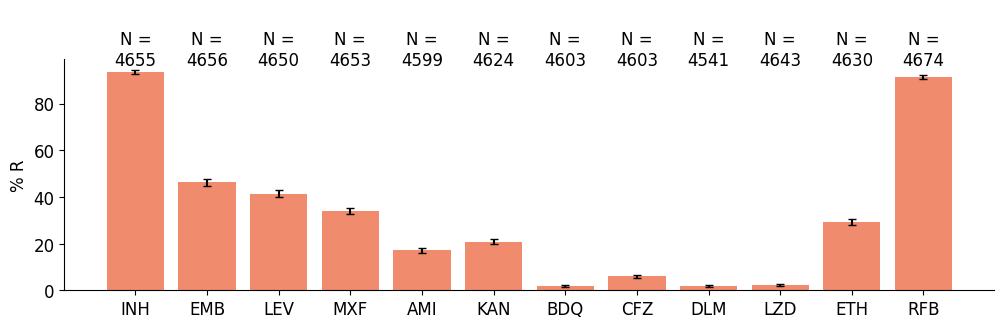

In [274]:
other_drug_names=['INH','EMB','LEV','MXF','AMI','KAN','BDQ','CFZ','DLM','LZD','ETH', 'RFB']
make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF)==1], other_drug_names, '#f08b6d', 'MDR_other_ci.png')

7414
[1470, 92, 209, 132, 84, 147, 24, 246, 99, 46, 353, 140] [7258, 7338, 7351, 7371, 7328, 7340, 7293, 7292, 7232, 7377, 7332, 7309]
INH 0.20253513364563241 UB= 21.169033837833926 LB= 19.337992891292554
EMB 0.012537476151539929 UB= 1.490164617800439 LB= 1.0173306125075465
LEV 0.028431505917562237 UB= 3.205520000530319 LB= 2.4807811829821285
MXF 0.01790801790801791 UB= 2.0756250721069884 LB= 1.5059785094965932
AMI 0.01146288209606987 UB= 1.3718024763833407 LB= 0.9207739428306334
KAN 0.02002724795640327 UB= 2.3052898857930377 LB= 1.7001597054876167
BDQ 0.003290826820238585 UB= 0.4424260674419823 LB= 0.21573929660573468
CFZ 0.03373560065825562 UB= 3.7704793154441214 LB= 2.976640816207003
DLM 0.013689159292035399 UB= 1.6183210314449572 LB= 1.1195108269621223
LZD 0.0062355971262030635 UB= 0.785092386685029 LB= 0.4620270385555836
ETH 0.04814511729405346 UB= 5.287790476192694 LB= 4.341232982617998
RFB 0.019154467095361883 UB= 2.2116476285132345 LB= 1.619245790559142


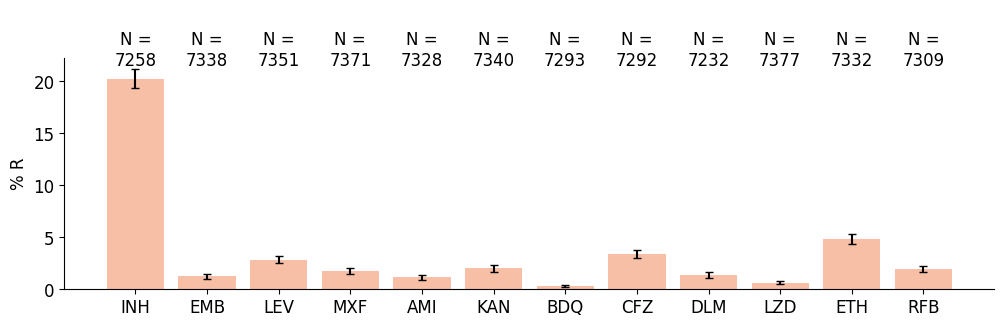

In [275]:
make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF==0)], 
                        other_drug_names, '#f6bfa6', 'R_ci.png')

302
[0, 13, 19, 14, 14, 21, 7, 24, 8, 5, 16, 256] [302, 300, 297, 297, 295, 297, 298, 296, 287, 299, 292, 301]
INH 0.0 UB= -0.030107620973949242 LB= 0.030107620973949242
EMB 0.043333333333333335 UB= 6.240940695757986 LB= 2.4257259709086822
LEV 0.06397306397306397 UB= 8.794377529427804 LB= 4.00023526518499
MXF 0.04713804713804714 UB= 6.726055849496621 LB= 2.7015535781128057
AMI 0.04745762711864407 UB= 6.771525015672183 LB= 2.72000040805663
KAN 0.0707070707070707 UB= 9.605649549982498 LB= 4.535764591431643
BDQ 0.02348993288590604 UB= 3.6648547488330223 LB= 1.0331318283481856
CFZ 0.08108108108108109 UB= 10.845326736437723 LB= 5.370889479778495
DLM 0.027874564459930314 UB= 4.273099394495829 LB= 1.301813497490234
LZD 0.016722408026755852 UB= 2.727240748983788 LB= 0.6172408563673828
ETH 0.0547945205479452 UB= 7.690232601742768 LB= 3.268671507846273
RFB 0.8504983388704319 UB= 89.70068855100047 LB= 80.39897922308592


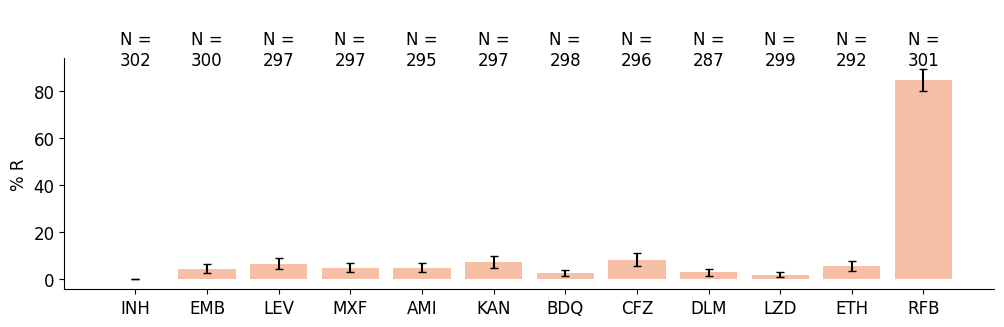

In [276]:
make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF==1) & (drugs_df.INH==0)], 
                        other_drug_names, '#f6bfa6', 'RIFR_other_ci.png')

1470
[1470, 69, 82, 58, 34, 47, 9, 69, 25, 15, 298, 98] [1470, 1442, 1459, 1462, 1457, 1458, 1454, 1449, 1431, 1465, 1453, 1444]
INH 1.0 UB= 100.32495103209709 LB= 99.67504896790291
EMB 0.0478502080443828 UB= 5.8024916437405905 LB= 3.767549965135969
LEV 0.05620287868403016 UB= 6.720552308996515 LB= 4.520023427809516
MXF 0.03967168262653899 UB= 4.883019592387439 LB= 3.051316932920358
AMI 0.023335621139327384 UB= 3.0212011488302633 LB= 1.6459230790352137
KAN 0.03223593964334705 UB= 4.044006712091601 LB= 2.403181216577808
BDQ 0.006189821182943604 UB= 0.9355904001117787 LB= 0.3023738364769419
CFZ 0.047619047619047616 UB= 5.774542466773241 LB= 3.7492670570362834
DLM 0.017470300489168415 UB= 2.3362473178432053 LB= 1.157812779990478
LZD 0.010238907849829351 UB= 1.4520748015971738 LB= 0.5957067683686963
ETH 0.2050929112181693 UB= 22.539418654597252 LB= 18.479163589036606
RFB 0.06786703601108034 UB= 8.004172343978043 LB= 5.569234858238024


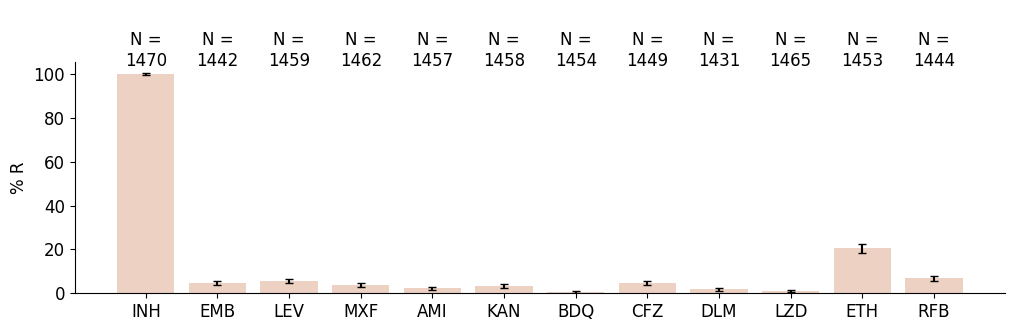

In [277]:
make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF==0) & (drugs_df.INH==1) & (drugs_df.sum(axis=1)>=1)], 
                        other_drug_names, '#edd1c2', 'INHR_other_ci.png')

142
[137, 95, 138, 122, 62, 64, 62, 57, 24, 92, 71, 135] [140, 141, 141, 141, 135, 139, 139, 138, 128, 140, 138, 142]
INH 0.9785714285714285 UB= 102.33229476015835 LB= 93.38199095412735
EMB 0.6737588652482269 UB= 75.85178791772105 LB= 58.899985131924325
LEV 0.9787234042553191 UB= 102.31719932186957 LB= 93.42748152919427
MXF 0.8652482269503546 UB= 93.5420920892751 LB= 79.50755330079583
AMI 0.45925925925925926 UB= 54.45830525423044 LB= 37.39354659762141
KAN 0.460431654676259 UB= 54.45671359862063 LB= 37.62961733663118
BDQ 0.4460431654676259 UB= 52.95592381297868 LB= 36.2527092805465
CFZ 0.41304347826086957 UB= 49.51747671496851 LB= 33.0912189372054
DLM 0.1875 UB= 24.891316820233342 LB= 12.608683179766658
LZD 0.6571428571428571 UB= 74.26857898515706 LB= 57.15999244341436
ETH 0.5144927536231884 UB= 60.067709164326544 LB= 42.83084156031113
RFB 0.9507042253521126 UB= 100.41688575795102 LB= 89.72395931247151


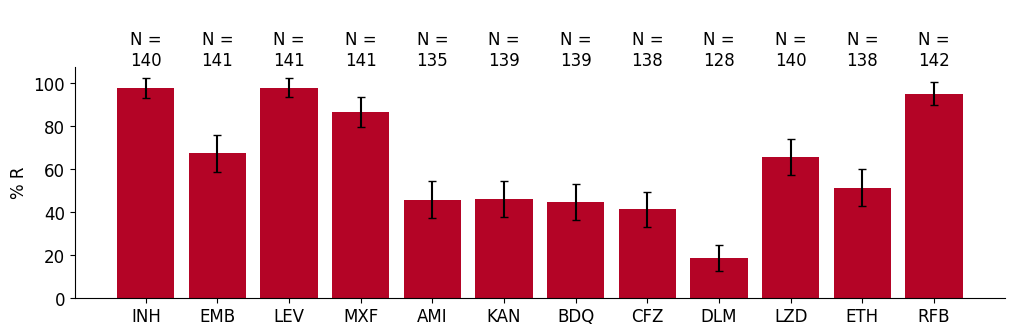

In [278]:
make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF==1) & ((drugs_df.LEV==1) | (drugs_df.MXF==1)) & ((drugs_df.BDQ==1)|(drugs_df.LZD==1))], 
                        other_drug_names, '#b40426', 'XDR_other_ci.png')

1961
[1936, 1210, 1925, 1585, 562, 656, 62, 179, 43, 92, 820, 1874] [1955, 1950, 1958, 1956, 1929, 1940, 1920, 1932, 1894, 1945, 1948, 1958]
INH 0.9902813299232737 UB= 99.60025308952558 LB= 98.45601289512916
EMB 0.6205128205128205 UB= 64.25269744008922 LB= 59.84986666247488
LEV 0.9831460674157303 UB= 99.0162817522722 LB= 97.61293173087385
MXF 0.8103271983640081 UB= 82.85673428617848 LB= 79.20870538662315
AMI 0.2913426645930534 UB= 31.144272198833523 LB= 27.12426071977716
KAN 0.33814432989690724 UB= 35.91111186411911 LB= 31.71775411526234
BDQ 0.03229166666666667 UB= 3.954136649995771 LB= 2.504196683337563
CFZ 0.09265010351966874 UB= 10.502524591628347 LB= 8.0274961123054
DLM 0.02270327349524815 UB= 2.873384281966482 LB= 1.667270417083149
LZD 0.04730077120822622 UB= 5.610785946226444 LB= 3.8493682954187998
ETH 0.4209445585215606 UB= 44.29469969271817 LB= 39.89421201159395
RFB 0.9570990806945863 UB= 96.72856180165235 LB= 94.6912543372649


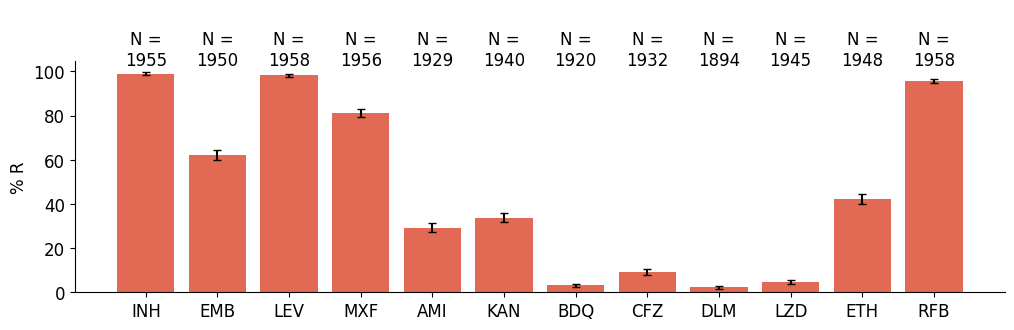

In [279]:
make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF==1) & ((drugs_df.LEV==1) | (drugs_df.MXF==1))], 
                        other_drug_names, '#e26953', 'PRE_XDR_other_ci.png')

In [346]:
#load in mutations data
mutations = pd.read_pickle(file_path+'/MUTATIONS_GPI.pkl.gz')
mutations.reset_index(inplace=True)

In [ ]:
#dicitonary of most common resistance associated mutations for each drug
mutations_dict={'RIF':[('rpoB', 'S450L'),
                       ('rpoB', 'D435V'), 
                       ('rpoB',  'H445D'), 
                       ('rpoB', 'H445Y'), 
                       ('rpoB','D435Y')],
               'INH':[('katG', 'S315T'),
                       ('fabG1', 'c-15t'), 
                       ('fabG1',  'g-17t'), 
                       ('fabG1', 't-8c'), 
                       ('inhA','I194T')],
               'EMB':[('embB', 'M306V'),
                       ('embB', 'M306I'), 
                       ('embB',  'Q497R'), 
                       ('embB', 'G406A'), 
                       ('embB','G406D')],
               'KAN':[('rrs', 'a1401g'),
                       ('eis', 'c-14t'), 
                       ('eis',  'g-10a')],
               'AMI':[('rrs', 'a1401g'),
                       ('rrs', 'g1484t')],
               'LEV':[('gyrA', 'D94G'),
                       ('gyrA', 'A90V'), 
                       ('gyrA',  'D94N'), 
                       ('gyrA', 'D94A'), 
                       ('gyrA','S91P')],
               'MXF':[('gyrA', 'D94G'),
                       ('gyrA', 'A90V'), 
                       ('gyrA',  'D94N'), 
                       ('gyrA', 'D94A'), 
                       ('gyrA','D94Y')],
               'ETH':[('fabG1', 'c-15t'),
                       ('fabG1', 'L203L')]}

In [368]:
#calculate number of resistant isolates with each mutation
drug=[]
n=[]
tot=[]
mut=[]
gene=[]

for i in ['RIF','INH','EMB','KAN','AMI','LEV','MXF','ETH']:
    drug_subset=gps.loc[gps.DRUG==i]
    gpsm = pd.merge(drug_subset,mutations,how='left',on='UNIQUEID') 
    for ii in range(len(mutations_dict[i])):
        drug.append(i)
        tot.append(gpsm.loc[(gpsm.BINARY_PHENOTYPE=='R')].UNIQUEID.nunique())
        n.append(gpsm.loc[(gpsm.BINARY_PHENOTYPE=='R')&
        (gpsm.GENE==mutations_dict[i][ii][0])&(gpsm.MUTATION==mutations_dict[i][ii][1])].UNIQUEID.nunique())
        gene.append(mutations_dict[i][ii][0])
        mut.append(mutations_dict[i][ii][1])
                            
print(drug)
print(n)
print(tot)
print(gene)
print(mut)
                            
r_mutations_df=pd.DataFrame(list(zip(drug,gene,mut,n,tot)), 
                 columns=['DRUG','GENE','MUTATION','N','TOTAL'])        

['RIF', 'RIF', 'RIF', 'RIF', 'RIF', 'INH', 'INH', 'INH', 'INH', 'INH', 'EMB', 'EMB', 'EMB', 'EMB', 'EMB', 'KAN', 'KAN', 'KAN', 'AMI', 'AMI', 'LEV', 'LEV', 'LEV', 'LEV', 'LEV', 'MXF', 'MXF', 'MXF', 'MXF', 'MXF', 'ETH', 'ETH']
[2914, 506, 202, 147, 112, 4578, 1125, 201, 163, 62, 834, 473, 318, 65, 34, 648, 57, 31, 627, 5, 753, 464, 152, 119, 88, 697, 316, 148, 87, 64, 853, 118]
[4685, 4685, 4685, 4685, 4685, 5909, 5909, 5909, 5909, 5909, 2261, 2261, 2261, 2261, 2261, 1121, 1121, 1121, 883, 883, 2146, 2146, 2146, 2146, 2146, 1724, 1724, 1724, 1724, 1724, 1727, 1727]
['rpoB', 'rpoB', 'rpoB', 'rpoB', 'rpoB', 'katG', 'fabG1', 'fabG1', 'fabG1', 'inhA', 'embB', 'embB', 'embB', 'embB', 'embB', 'rrs', 'eis', 'eis', 'rrs', 'rrs', 'gyrA', 'gyrA', 'gyrA', 'gyrA', 'gyrA', 'gyrA', 'gyrA', 'gyrA', 'gyrA', 'gyrA', 'fabG1', 'fabG1']
['S450L', 'D435V', 'H445D', 'H445Y', 'D435Y', 'S315T', 'c-15t', 'g-17t', 't-8c', 'I194T', 'M306V', 'M306I', 'Q497R', 'G406A', 'G406D', 'a1401g', 'c-14t', 'g-10a', 'a1401g', 

In [369]:
#calculate percentages and save table
r_mutations_df['%']=r_mutations_df['N']/r_mutations_df['TOTAL']*100
r_mutations_df.to_csv('R_mutations.csv')
r_mutations_df

,DRUG,GENE,MUTATION,N,TOTAL
0,RIF,rpoB,S450L,2914,4685
1,RIF,rpoB,D435V,506,4685
2,RIF,rpoB,H445D,202,4685
3,RIF,rpoB,H445Y,147,4685
4,RIF,rpoB,D435Y,112,4685
5,INH,katG,S315T,4578,5909
6,INH,fabG1,c-15t,1125,5909
7,INH,fabG1,g-17t,201,5909
8,INH,fabG1,t-8c,163,5909
9,INH,inhA,I194T,62,5909
